# Load dataset and packages

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
from sklearn import preprocessing
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.cluster import DBSCAN
from scipy.stats import probplot
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
! pip install -q kaggle 
#to force update Kaggle API
#!pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#if Google Drive mounted with API credential
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#to check if API is working
#! kaggle datasets list

In [3]:
! kaggle datasets download -d jackdaoud/marketing-data

  0% 0.00/60.8k [00:00<?, ?B/s]
100% 60.8k/60.8k [00:00<00:00, 44.3MB/s]


In [4]:
!unzip marketing-data.zip

Archive:  marketing-data.zip
  inflating: marketing_data.csv      


In [21]:
df = pd.read_csv('marketing_data.csv')

In [24]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Expenditure,Age
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,2014-06-16,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,SP,1190,51
1,1,1961,Graduation,Single,"$57,091.00",0,0,2014-06-15,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,CA,577,60
2,10476,1958,Graduation,Married,"$67,267.00",0,1,2014-05-13,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,US,251,63
3,1386,1967,Graduation,Together,"$32,474.00",1,1,2014-05-11,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS,11,54
4,5371,1989,Graduation,Single,"$21,474.00",1,0,2014-04-08,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,SP,91,32


In [9]:
df.shape

(2240, 28)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4    Income              2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

#EDA & Data Wrangling

In [11]:
def wrangle(data):

  # Merging the rows of Marital Status
  data['Marital_Status'] = data['Marital_Status'].replace(["Alone","YOLO","Absurd"],"Single")
  print(data['Marital_Status'].unique())

  # Merging the rows of education variable:
  data['Education'] = data['Education'].replace(["2n Cycle","Master"],"Masters")
  print(data['Education'].unique())

  # Convert to datetime
  data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format='%m/%d/%y')

  # New variable: Expenditure
  data['Expenditure'] = data['MntWines'] + data['MntSweetProducts'] + data['MntMeatProducts']+ data['MntGoldProds'] + data['MntFruits'] + data['MntFishProducts'] 

  # New variable: Age
  data['Age'] = 2021 - data['Year_Birth']

  return data

In [23]:
wrangle(df)

['Divorced' 'Single' 'Married' 'Together' 'Widow']
['Graduation' 'PhD' 'Masters' 'Basic']


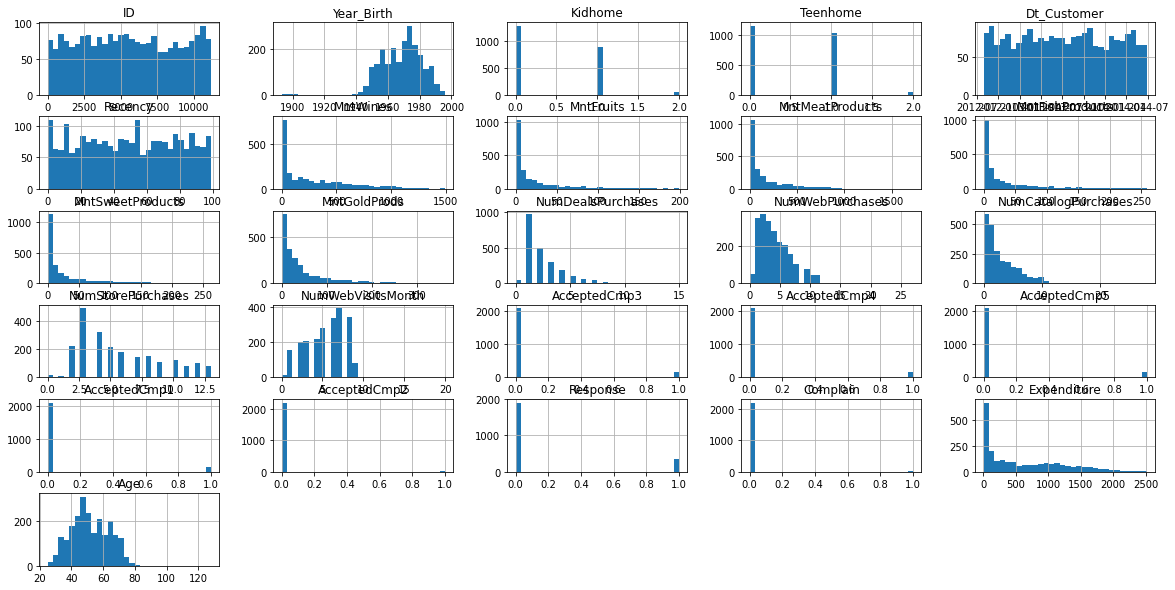

In [25]:
df[list(df.columns[:])].hist(bins=30, figsize=(20, 10));

#RFM analysis

In [27]:
# Calculating Frequency:
df['Frequency'] = df['NumStorePurchases'] + df['NumCatalogPurchases'] + df['NumWebPurchases']

# Renaming the variables of recency ,Expenditure to Monetory , Recent_purchase.
df.rename(columns = {'Expenditure':'Monetory','Recency':'Recent_Purchase'}, inplace = True)

In [28]:
# Creating a dataframe of Spain
df_spain = df[(df['Country'] == 'SP')].reset_index(drop = True)
df_spain = pd.DataFrame(df_spain[['ID','Recent_Purchase','Frequency','Monetory']])
df_spain.head()

,ID,Recent_Purchase,Frequency,Monetory
0,1826,0,14,1190
1,5371,0,6,91
2,7348,0,16,1192
3,1991,0,6,96
4,5642,0,10,222


In [29]:
quantiles_recency = df_spain.quantile(q = [0.25,0.50,0.75])
quantiles_recency

,ID,Recent_Purchase,Frequency,Monetory
0.25,2802.0,24.5,6.0,67.5
0.50,5371.0,51.0,12.0,367.0
0.75,8423.5,74.0,19.0,1045.0


In [30]:
# Creating functions to determine the RFM score:
def R_score(data):
    if data < quantiles_recency['Recent_Purchase'][0.25]:
        return 3
    elif data < quantiles_recency['Recent_Purchase'][0.75]:
        return 2
    else:
        return 1
    
def F_score(data):
    if data < quantiles_recency['Frequency'][0.25]:
        return 3
    elif data < quantiles_recency['Frequency'][0.75]:
        return 2
    else:
        return 1    
    
    
def M_score(data):
    if data < quantiles_recency['Monetory'][0.25]:
        return 3
    elif data < quantiles_recency['Monetory'][0.75]:
        return 2
    else:
        return 1  

In [31]:
df_spain['R_score'] = df_spain.Recent_Purchase.apply(lambda x : R_score(x))
df_spain['F_score'] = df_spain.Frequency.apply(lambda x : F_score(x))
df_spain['M_score'] = df_spain.Monetory.apply(lambda x : M_score(x))
df_spain['rfm_score'] = df_spain['R_score'].map(str) + df_spain['F_score'].map(str) + df_spain['M_score'].map(str) 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

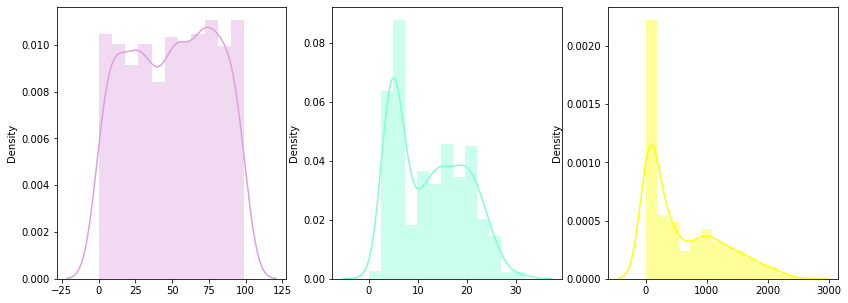

In [32]:
plt.figure(figsize = (14,5))

plt.subplot(1,3, 1)
sns.distplot(x = df_spain['Recent_Purchase'], kde = True, color = 'plum')

plt.subplot(1,3,2)
sns.distplot(x = df_spain['Frequency'], kde = True, color = 'aquamarine')

plt.subplot(1,3,3)
sns.distplot(x = df_spain['Monetory'], kde = True, color = 'yellow')